# <font color='green'>Lessons from classical error correction</font>

Several of the key ingredients in quantum error correction can be intuitively understood by starting with the classical setting. In this chapter, we will walk through an example inspired by classical error correction. Throughout the discussion, we will demonstrate the results in Python.

In [1]:
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plotter
plotter.rcParams['font.family'] = 'Monospace'

## <font color='blue'>A classical error correction scenario</font>

Imagine two parties (a sender and a receiver) communicating across a noisy channel. The effect of the noisy channel is to corrupt the communication between the two parties by introducing an error.

The sender transmits one bit (0 or 1) of information at a time, and the receiver gets each of those bits on the other side, but the noisy channel flips some of them from 0 to 1 (or vice versa). 

To overcome the errors caused by the noisy channel, they agree on the simplest error-correcting protocol: let's repeat the same message multiple times. The receiver then takes a majority vote of all the repeated bits to determine what the original message was. In error correction terminology, the two parties are communicating using a repetition code, with code distance equal to the number of times the message is copied/repeated.

Below, we write three functions to capture the communication between the two parties. The `encode` function creates `num_copies` copies of one `bit` of information. This is the message that the sender intends to transmit. Then, the `send` function takes those `bits`, and corrupts some of them with probability `p_error` by flipping them from 0 to 1 (or vice versa). Finally, the `receive_and_interpret` function takes in those `bits` and, depending on whether the `majority_vote` flag is set, returns either a single bit that won the majority vote, or the count of how many 0 and 1 bits were received.

In [2]:
def encode(bit, num_copies):
    return [bit] * num_copies

def send(bits, p_error = 0.1):
    return [1^bit if random.random() <= p_error else bit for bit in bits]

def receive_and_interpret(bits, majority_vote = False):
    received_bits_counted = Counter(bits).most_common()
    if majority_vote:
        return received_bits_counted[0][0]
    else:
        return received_bits_counted

Now, we can use these functions to demonstrate the key ingredients of error correction.

For example, we can encode the message `1` repeatedly by writing

In [3]:
message = encode(1, 5)
print(message)

[1, 1, 1, 1, 1]


We can then transmit this message across a noisy channel by writing

In [4]:
transmitted = send(message, p_error = 0.1)
print(transmitted)

[0, 1, 1, 1, 1]


And finally, we can interpret what these bits could have meant by writing

In [5]:
received = receive_and_interpret(transmitted)
print(received)

[(1, 4), (0, 1)]


where we see how many 0s and 1s were received, or take a majority vote by writing

In [6]:
received = receive_and_interpret(transmitted, majority_vote = True)
print(received)

1


## <font color='blue'>Measuring the effectiveness of classical repetition codes</font>

Now, let's ask the following question: how well does this duplicate-and-take-majority-vote scheme work?

To do this, we run several iterations (`n_shots`) where we send a randomly picked message across the channel to see when we can successfully recover the desired message. We will count the number of times we are unable to recover the desired message, and report it as a probability in `n_shots` attempts.

In [7]:
def get_code_error_probability(code_distance, p_error, n_shots = 1000):

    code_errors = 0.0
    for _ in range(n_shots):
        desired_message = random.choice([0,1])

        encoded_message = encode(desired_message, num_copies = code_distance)
        sent_message = send(encoded_message, p_error = p_error)
        received_message = receive_and_interpret(sent_message, majority_vote = True)

        if received_message != desired_message:
            code_errors += 1

    return code_errors / n_shots

We will try several code distances to see the impact of increasing the code distance. Note that we are only using odd-numbered distances $(1,3,5,\ldots)$ so that we can ensure that majority voting works.

In [8]:
code_distances = np.arange(start = 1, stop = 21, step = 2)
p_errors = np.logspace(start = -3, stop = 0, num = 50)

all_code_distance_error_probabilities = []
for code_distance in code_distances:
    print(f"Running distance {code_distance}")
    code_distance_error_probabilities = []
    for p_error in p_errors:
        code_distance_error_probabilities.append(
            get_code_error_probability(code_distance, p_error, n_shots = 100000)
        )
    all_code_distance_error_probabilities.append(code_distance_error_probabilities)

Running distance 1
Running distance 3
Running distance 5
Running distance 7
Running distance 9
Running distance 11
Running distance 13
Running distance 15
Running distance 17
Running distance 19


Now, we can plot the results to see the effectiveness of the error-correcting scheme.

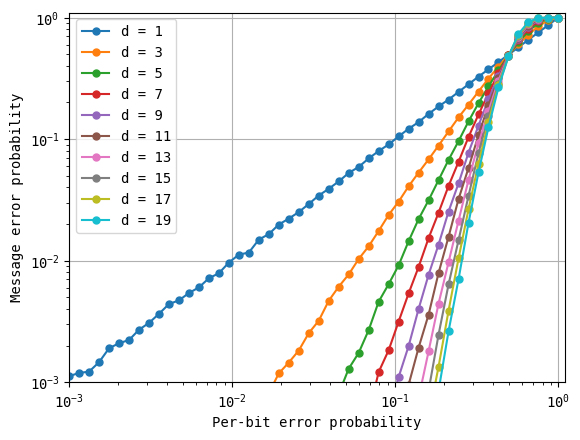

In [18]:
for code_distance, error_probabilities in zip(code_distances, all_code_distance_error_probabilities):
    plotter.loglog(p_errors, error_probabilities, marker = '.', markersize = 10, label=f'd = {code_distance}')
plotter.legend()
plotter.xlabel('Per-bit error probability')
plotter.ylabel('Message error probability')
plotter.xlim([1e-3, 1.1])
plotter.ylim([1e-3, 1.1])
plotter.grid()
plotter.show()

First, note that code distance `d = 1` has no effect on the message. When the probability of error introduced by the channel (the x-axis labeled per-bit error probability) is $10^{-2}$, so is the probability of error of the encoded message (the y-axis labeled message error probability). However, for larger distances, a reduction in the per-bit error probability leads to steeper reductions in the error of the encoded message. For example, at distance $3$, the same per-bit error probability leads to an error in the received message that is well below $10^{-3}$, a 10x improvement.

To see the effect of error correction more clearly, we take a vertical slice of the above plot for a specific value of per-bit error probability, and see what happens at various code distances.

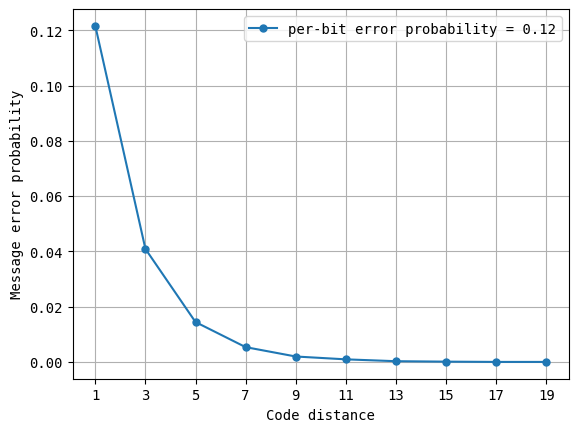

In [26]:
specific_p_error = 0.12
idx = np.searchsorted(p_errors, specific_p_error, side="left")
message_error_probabilities_for_p_error = [all_code_distance_error_probabilities[i][idx] for i in range(len(code_distances))]
plotter.plot(code_distances, message_error_probabilities_for_p_error, marker = '.', markersize = 10, label = f'per-bit error probability = {specific_p_error}')
plotter.xlabel('Code distance')
plotter.ylabel('Message error probability')
plotter.xticks(code_distances)
plotter.legend()
plotter.grid()
plotter.show()

As you can see, increasing code distances result in an exponential suppression of the per-bit error. For the specific value of `p_error = 0.12`, the error of the message being misinterpreted is already down 3x at code distance 3, and $\sim8$x at code distance 5.

## <font color='blue'>The presence of a threshold</font>

The astute reader may have noticed in the above plots that error correction makes things worse (and not better) when the per-bit error is large. We can see this more clearly by replotting as shown below.

In [27]:
code_distances = np.arange(start = 1, stop = 21, step = 2)
p_errors = np.linspace(start = 0.1, stop = 1, num = 10)

all_code_distance_error_probabilities = []
for code_distance in code_distances:
    print(f"Running distance {code_distance}")
    code_distance_error_probabilities = []
    for p_error in p_errors:
        code_distance_error_probabilities.append(
            get_code_error_probability(code_distance, p_error, n_shots = 100000)
        )
    all_code_distance_error_probabilities.append(code_distance_error_probabilities)

Running distance 1
Running distance 3
Running distance 5
Running distance 7
Running distance 9
Running distance 11
Running distance 13
Running distance 15
Running distance 17
Running distance 19


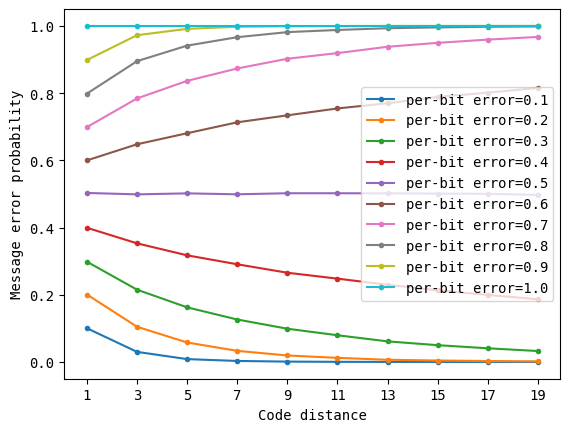

In [31]:
for ii in range(0, len(p_errors), 1):
    error_probabilities = [all_code_distance_error_probabilities[j][ii] for j in range(len(code_distances))]
    plotter.plot(code_distances, error_probabilities, marker = '.', label=f'per-bit error={p_errors[ii]:.1f}')
plotter.xticks(code_distances)
plotter.legend()
plotter.xlabel('Code distance')
plotter.ylabel('Message error probability')
plotter.show()

As you can see above, as the per-bit error probability crosses $0.5$, the effect of our error correction scheme flips. When the noisy channel is simply too noisy (and therefore the per-bit error probability is larger than $0.5$), error correction doesn't help at all -- in fact, it makes things worse because each redundantly added bit is unlikely to help the situation. However, when the noisy channel is good enough (with a per-bit error probability less than $0.5$), the benefits of our error correction scheme appear clearly, resulting in an improvement in chance of success that the received message is interpreted successfully. The specific value of the per-bit error probability where the effect of error correction flips sharply is known as the _threshold_. From an engineering standpoint, we want to create a noisy channel that is at least that good, so that we can employ error correction and achieve low overall errors.

<details>
    <summary>Easter egg</summary>
    The above plot appears on the cover page of the textbook. However, note that the plot on the cover has a y-axis that extends to the $10^{-9}$ range. Doing this requires taking a few billion shots of statistics. This takes a lot of time to do, but you will learn the techniques to speed up these simulations later in this textbook.
</details>